<a href="https://colab.research.google.com/github/JP109/NLP/blob/main/Sentiment_Analysis_on_IMDB_reviews_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **1. Imports**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import os
from IPython.display import HTML

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text 
from sklearn.decomposition import PCA

from tensorflow.python.keras.models import Sequential, load_model
from tensorflow.python.keras.layers import Dense, Dropout
from tensorflow.python.keras import optimizers

import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import words
from nltk.corpus import wordnet 

import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings('ignore')

import nltk
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re,string,unicodedata
from bs4 import BeautifulSoup

In [2]:
from google.colab import files
data = files.upload()

Saving IMDB Dataset.csv to IMDB Dataset.csv


In [3]:
imdb_data = pd.read_csv('IMDB Dataset.csv')

### **2. Data visualization and preprocessing**

In [4]:
imdb_data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
imdb_data.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,negative
freq,5,25000


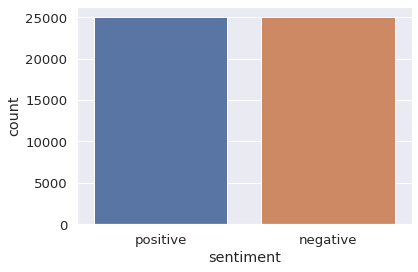

In [6]:
sns.set(style = "darkgrid" , font_scale = 1.2)
sns.countplot(imdb_data.sentiment)

In [7]:
imdb_data.isna().sum() # Checking for any missing values

review       0
sentiment    0
dtype: int64

In [8]:
nltk.download('stopwords')
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


**Data cleaning**

In [9]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop and i.strip().lower().isalpha():
            final_text.append(i.strip().lower())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(denoise_text)

In [10]:
imdb_data.sentiment.replace("positive" , 1 , inplace = True)
imdb_data.sentiment.replace("negative" , 0 , inplace = True)
imdb_data.head()

,review,sentiment
0,one reviewers mentioned watching oz episode ex...,1
1,wonderful little filming technique fashion giv...,1
2,thought wonderful way spend time hot summer si...,1
3,basically family little boy thinks zombie clos...,0
4,petter time visually stunning film mattei offe...,1


**Wordcloud for positive text**

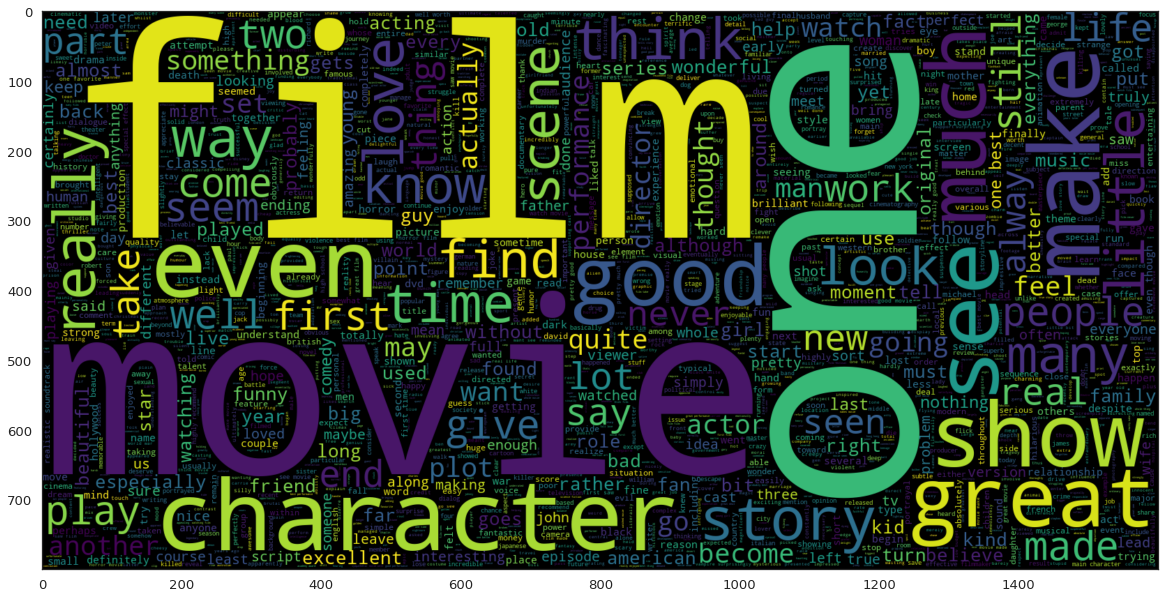

In [11]:
sns.set(style = "white" , font_scale = 1.2)
plt.figure(figsize = (20,20)) # Positive Review Text
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(imdb_data[imdb_data.sentiment == 1].review))
plt.imshow(wc , interpolation = 'bilinear')

**Wordcloud for negative text**

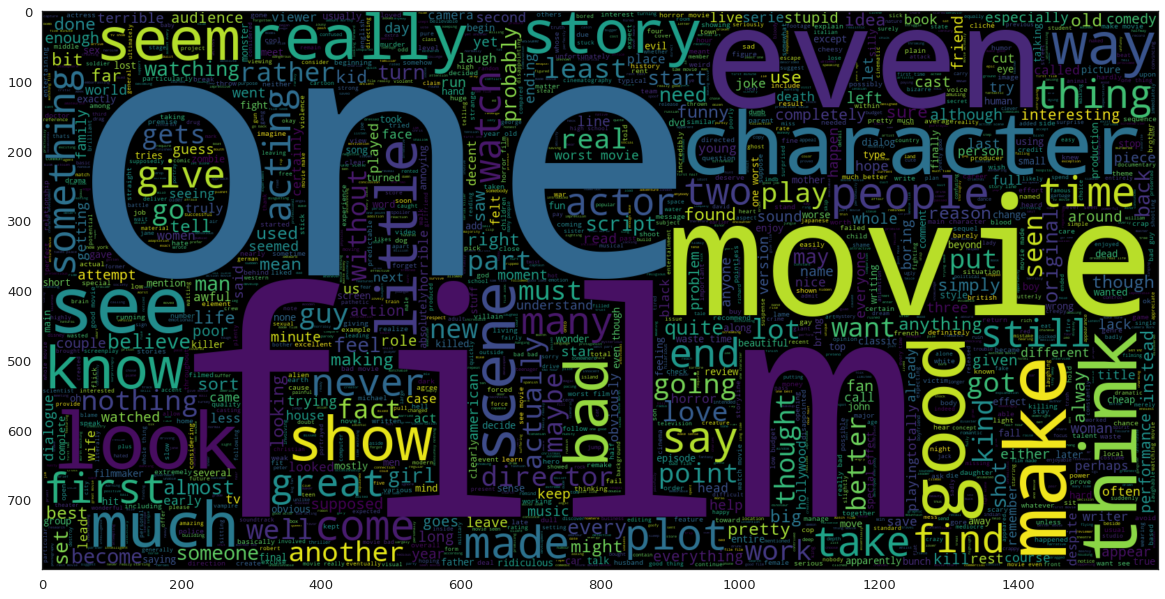

In [12]:
plt.figure(figsize = (20,20)) # Negative Review Text
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(imdb_data[imdb_data.sentiment == 0].review))
plt.imshow(wc , interpolation = 'bilinear')

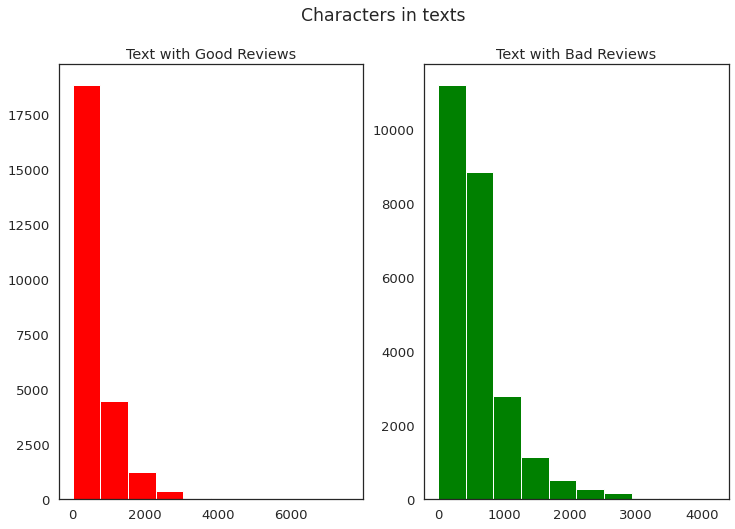

In [13]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=imdb_data[imdb_data['sentiment']==1]['review'].str.len()
ax1.hist(text_len,color='red')
ax1.set_title('Text with Good Reviews')
text_len=imdb_data[imdb_data['sentiment']==0]['review'].str.len()
ax2.hist(text_len,color='green')
ax2.set_title('Text with Bad Reviews')
fig.suptitle('Characters in texts')
plt.show()

### **Tokenization**

In [14]:
from nltk.stem.porter import PorterStemmer

porter = PorterStemmer()

def tokenizer(text):
  return text.split()

def tokenizer_stemmer(text):
  return[porter.stem(word) for word in text.split()]

tokenizer('runners like running thus they run')

['runners', 'like', 'running', 'thus', 'they', 'run']

In [15]:
tokenizer_stemmer('runners like running thus they run')

['runner', 'like', 'run', 'thu', 'they', 'run']

### **Transform Text Data into TF-IDF Vectors**

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(strip_accents=None,
                         lowercase=True,
                         preprocessor=None,  # applied preprocessor in Data Cleaning
                         tokenizer=tokenizer_stemmer,
                         use_idf=True,
                         norm='l2',
                         smooth_idf=True)

y = imdb_data.sentiment.values
X = tfidf.fit_transform(imdb_data.review)

### **Document Classification using Logistic Regression**

In [17]:
from sklearn.model_selection import train_test_split
import pickle
from sklearn.linear_model import LogisticRegressionCV


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.5, shuffle=False)

clf = LogisticRegressionCV(cv=5,
                           scoring='accuracy',
                           random_state=0,
                           n_jobs=-1,
                           verbose=3,
                           max_iter=300).fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.7min finished


In [18]:
saved_model = open('saved_model.sav', 'wb')
pickle.dump(clf, saved_model)
saved_model.close()

### **Model Evaluation**

In [19]:
filename = 'saved_model.sav'
saved_clf = pickle.load(open(filename, 'rb'))

In [20]:
clf.score(X_test, y_test)

0.8694

In [21]:
yhat = clf.predict(X_test)
yhat

array([0, 0, 1, ..., 1, 1, 0])

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print(confusion_matrix(y_test, yhat, labels=[1,0]))

[[11014  1512]
 [ 1753 10721]]


Confusion matrix, without normalization
[[11014  1512]
 [ 1753 10721]]


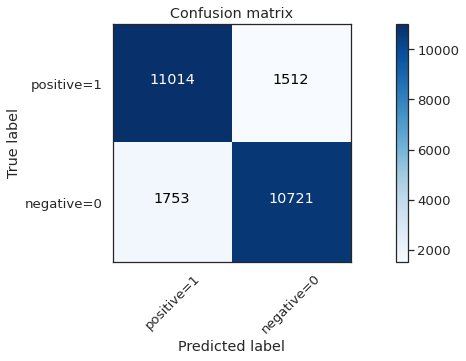

In [23]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure(figsize=(13,5))
plot_confusion_matrix(cnf_matrix, classes=['positive=1','negative=0'],normalize= False,  title='Confusion matrix')